# Google Revenue Prediction

## Kaggle Challenge Description

## What are we predicting?
We are predicting the **natural log** of the sum of all transactions **per user**.

$$ y_{user} = \sum_{i=1}^n transaction_{user_{i}} $$
$$ target_{user} = ln(y_{user} + 1) $$

## Data Cleansing 

Simply change csv_file to either "test_v2.csv" or "train_v2.csv" to determine which csv to use. Using "test_v2.csv" will make it easier to manage for your system.

In [110]:
%%time
import pandas as pd
import sklearn
from sklearn import model_selection, preprocessing, metrics
import json
import os
import matplotlib
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import numpy as np
import lightgbm as lgb


Wall time: 0 ns


In [111]:
%%time
data = 'data'
def load_csv(data, csv_file, nrows):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    print("Loading csv file")
    df = pd.read_csv(os.path.join(os.getcwd(),data,csv_file),
                    converters={column: json.loads for column in JSON_COLUMNS},
                    dtype={'fullVisitorId': 'str'},
                    nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["%s.%s" % (column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
#      Convert feature type
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].astype('float')
    
    return df

# Load both the training csv and testing csv
train_df = load_csv(data, "train_v2.csv",10000)
test_df = load_csv(data, "test_v2.csv", 2000)

print("Loading done.")


Loading csv file
Loading csv file
Loading done.
Wall time: 4.48 s


## Columns and Types
Initially we should dissect the data and learn what columns are found inside the csv file.

In [112]:
train_df.dtypes

channelGrouping                                       object
customDimensions                                      object
date                                                   int64
fullVisitorId                                         object
hits                                                  object
socialEngagementType                                  object
visitId                                                int64
visitNumber                                            int64
visitStartTime                                         int64
device.browser                                        object
device.browserSize                                    object
device.browserVersion                                 object
device.deviceCategory                                 object
device.flashVersion                                   object
device.isMobile                                         bool
device.language                                       object
device.mobileDeviceBrand

## Feature Engineering and Data Exploration

Create 4 additional features from *date* feature: year, month, day, weekday. We will use those to better understand our data.

In [113]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    return df
add_time_features(test_df)
temp_df = add_time_features(train_df)
time_agg = temp_df.groupby('date')['totals.transactionRevenue'].agg(['count', 'sum'])


### Data Exploration



Group date by date, year, month, day, weekday and aggregate by count/sum.

In [114]:
time_agg = train_df.groupby('date')['totals.transactionRevenue'].agg(['count', 'sum'])
year_agg = train_df.groupby('year')['totals.transactionRevenue'].agg(['sum'])
month_agg = train_df.groupby('month')['totals.transactionRevenue'].agg(['sum'])
day_agg = train_df.groupby('day')['totals.transactionRevenue'].agg(['sum'])
weekday_agg = train_df.groupby('weekday')['totals.transactionRevenue'].agg(['count','sum'])

**Sum of transactionRevenue, our target, through the time.**

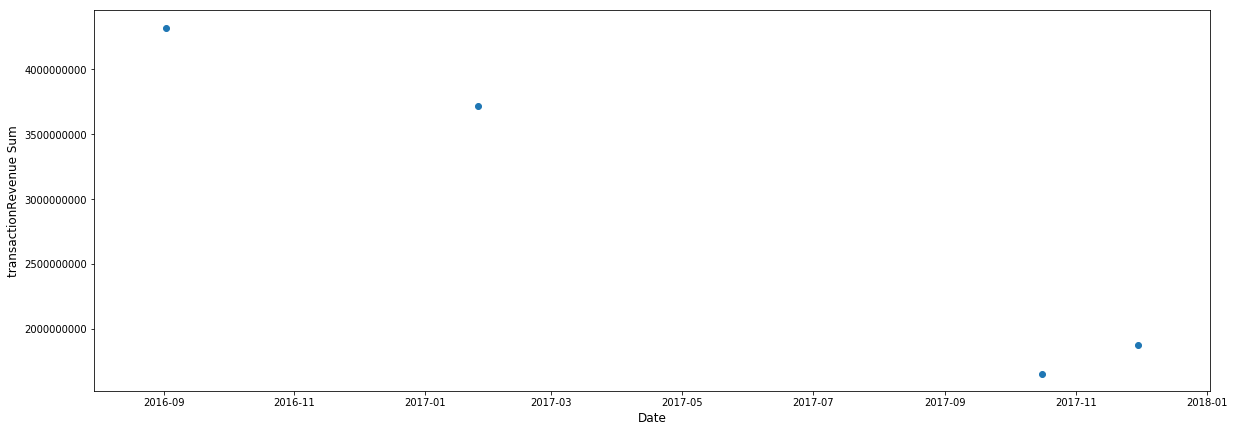

In [115]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('transactionRevenue Sum', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

**Count of transactionRevenue our target, through the same time period.**

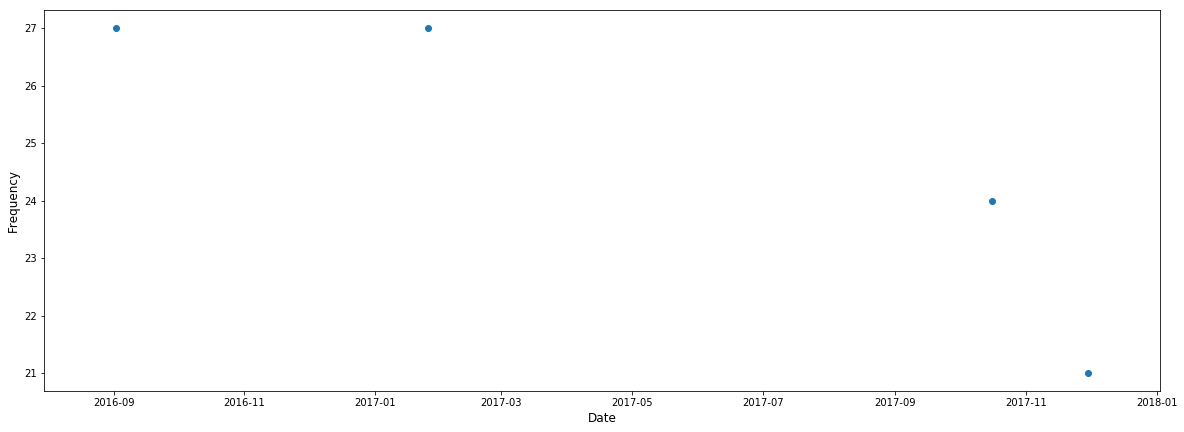

In [116]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

### Analyze engineered time features

**Sum of transactionRevenue over each year.**

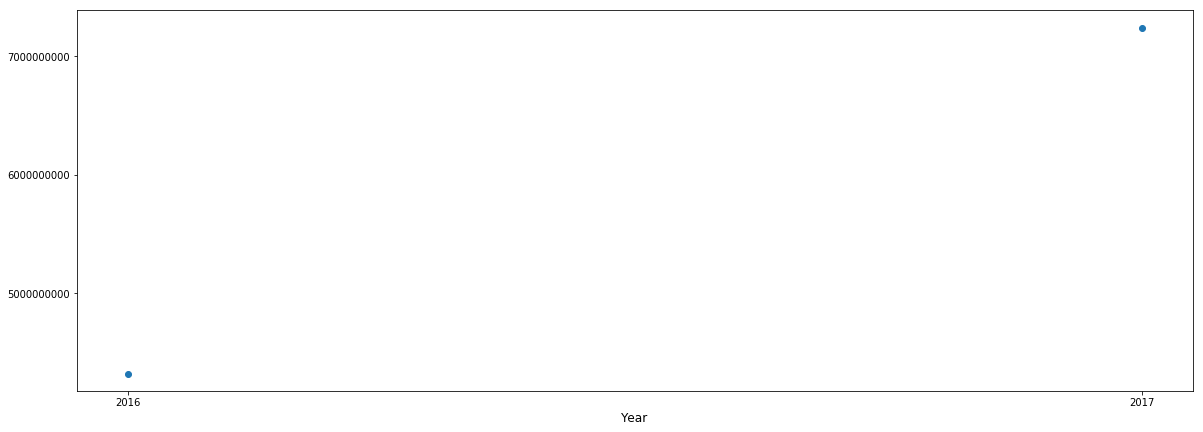

In [117]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Year', fontsize=12)
plt.locator_params(nbins=2)
plt.scatter(year_agg.index.values, year_agg['sum'])
plt.show()

**Sum of transactionRevenue by monthly**

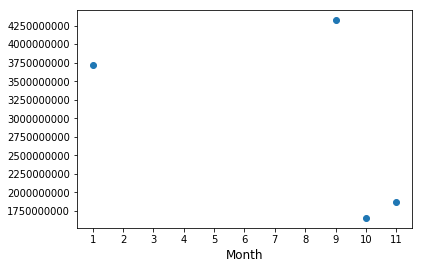

In [118]:
plt.scatter(month_agg.index.values, month_agg['sum'])
plt.locator_params(nbins=12)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Month', fontsize=12)
plt.show()

**Sum of transactionRevenue daily**

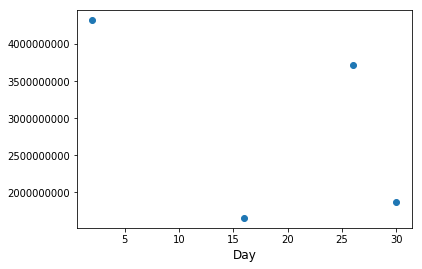

In [119]:
plt.scatter(day_agg.index.values, day_agg['sum'])
plt.locator_params(nbins=10)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Day', fontsize=12)
plt.show()

**Sum of transactionRevenue on weekdays**

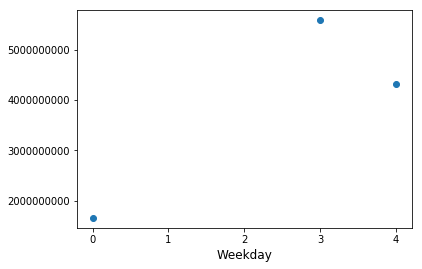

In [120]:
plt.scatter(weekday_agg.index.values, weekday_agg['sum'])
plt.locator_params(nbins=7)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Weekday', fontsize=12)
plt.show()

### Analyzing which Columns are constant

In [121]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

We should also remove the constant columns, as they will bring no bearing to the weights on the model.

In [122]:
cols_to_drop = const_cols
#+ ["trafficSource.campaignCode"]
train_df = train_df.drop(cols_to_drop,axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

# Target Variable Exploration

We need to sum up the transaction revenue on the user level. Then graph a scatter plot of the natural log.


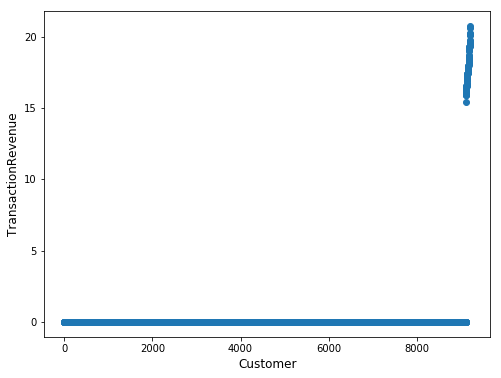

In [123]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('Customer', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

The scatter plot above confirms the 80/20 marketing principle that states 80% of the profits come from 20% of the customers.

From this analysis, this would mean that we have a distinct dataset between customers with TransactionRevenue and customers without TransactionRevenue.


# Developing the Model: LGBM
To discover which is the best model to predict the log revenue of customers. We can do a training analysis based on popular models such as LightGBM, ADABOOST and XGBOOST. All these models can be found in scikit-learn.

First, we need to build the training and testing dataset respectively.

In [124]:
## TODO: Create a template possible to fit with all the models.
## TODO: Write metrics visualization code.
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.metro", "geoNetwork.country",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

train_set,test_set = model_selection.train_test_split(train_df, test_size=0.2)
# We need to find the log of the transactionRevenue, such as seen in equation above.
train_values = np.log1p(train_set["totals.transactionRevenue"].values)
test_values = np.log1p(test_set["totals.transactionRevenue"].values)

train_set = train_set[cat_cols+num_cols]
test_set = test_set[cat_cols+num_cols]
test_X = test_df[cat_cols + num_cols]

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.metro
geoNetwork.country
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


## List of features for training the model

In [125]:
for x in train_set:
    print(x)

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.metro
geoNetwork.country
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
totals.hits
totals.pageviews
visitNumber
visitStartTime
totals.bounces
totals.newVisits


## LightGBM

In [126]:
## TODO: Build LightGBM training function.
def train_with_gbm(train_X,train_Y,val_x,val_y,test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_Y)
    lgval = lgb.Dataset(val_x, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_x, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = train_with_gbm(train_set, train_values, test_set, test_values, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.42292
Early stopping, best iteration is:
[76]	valid_0's rmse: 1.42019


## Deep Learning Approach

### Perform one-hot encoding on data